In [3]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd

pd.set_option("display.max_columns", 100)

# Matplotlib for visualization
from matplotlib import pyplot as plt

# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns

sns.set_style("darkgrid")

# Pickle for saving model files
import pickle

# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

# Import RandomForestClassifier and GradientBoostingClassifer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Function for splitting training and test set
from sklearn.model_selection import train_test_split

# Function for creating model pipelines
from sklearn.pipeline import make_pipeline

# StandardScaler
from sklearn.preprocessing import StandardScaler

# GridSearchCV
from sklearn.model_selection import GridSearchCV

# Classification metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

In [4]:
# Load analytical base table from Module 2
abt = pd.read_csv("analytical_base_table.csv")

In [5]:
# Create separate object for target variable
y = abt.status

# Create separate object for input variables
X = abt.drop("status", axis=1)

In [6]:
# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234, stratify=abt.status
)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

11254 2814 11254 2814


In [7]:
# Pipeline dictionary
pipelines = {
    "l1": make_pipeline(
        StandardScaler(),
        LogisticRegression(random_state=123, penalty="l1", solver="liblinear"),
    ),
    "l2": make_pipeline(
        StandardScaler(),
        LogisticRegression(random_state=123, penalty="l2", solver="liblinear"),
    ),
    "rf": make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
    "gb": make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123)),
}


## Delcare the hyperparameter grids

In [20]:
# Logistic Regression hyperparameters
l1_hyperparameters = {
    'logisticregression__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000],
}

l2_hyperparameters = {
    'logisticregression__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000],
}

# Random Forest hyperparameters
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['sqrt', 0.33],
    'randomforestclassifier__min_samples_leaf': [1, 3, 5, 10]
}

# Boosted Tree hyperparameters
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [100, 200],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth': [1, 3, 5]
}

In [21]:
# Create hyperparameters dictionary
hyperparameters = {
    "l1": l1_hyperparameters,
    "l2": l2_hyperparameters,
    "rf": rf_hyperparameters,
    "gb": gb_hyperparameters,
}
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)

    # Fit model on X_train, y_train
    model.fit(X_train, y_train)

    # Store model in fitted_models[name]
    fitted_models[name] = model

    # Print '{name} has been fitted'
    print(name, "has been fitted.")

l1 has been fitted.
l2 has been fitted.
rf has been fitted.
gb has been fitted.


## Model Evaluation

In [22]:
# Display best_score_ for each fitted model
for name, model in fitted_models.items():
    print(name, model.best_score_)

l1 0.8495639234260904
l2 0.8494751134793764
rf 0.9790293270179593
gb 0.9753868561278862


In [23]:
# Predict classes using L1-regularized logistic regression
pred = fitted_models["l1"].predict(X_test)
# Display first 10 predictions
print(pred[:10])

[False False False False False False False  True  True False]


In [24]:
# Display confusion matrix for y_test and pred
print(confusion_matrix(y_test, pred))

[[1968  173]
 [ 220  453]]


In [25]:
# Predict PROBABILITIES using L1-regularized logistic regression
pred = fitted_models["l1"].predict_proba(X_test)

# Get just the prediction for the positive class (1)
pred = [p[1] for p in pred]

# Display first 10 predictions
print(np.round(pred[:10], 2))

[0.03 0.   0.01 0.09 0.07 0.48 0.13 0.62 0.73 0.14]


In [26]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test, pred)

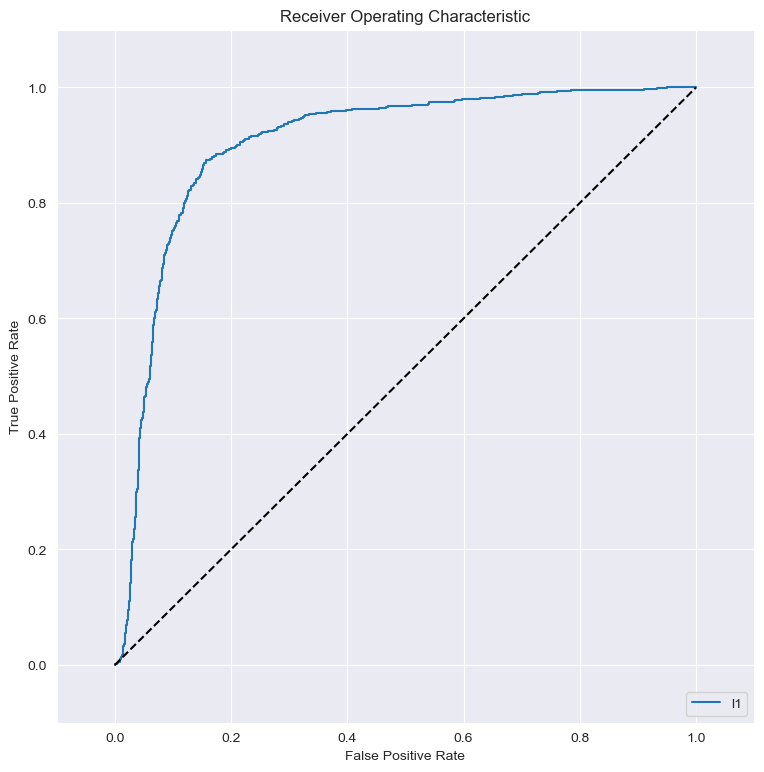

In [27]:
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Model Selection

In [28]:
# Calculate AUROC
print(roc_auc_score(y_test, pred))

0.9014777641365459


In [29]:
for name, model in fitted_models.items():
    pred = model.predict_proba(X_test)
    pred = [p[1] for p in pred]

    print(name, roc_auc_score(y_test, pred))

l1 0.9014777641365459
l2 0.9014652718834778
rf 0.9921389027498919
gb 0.9886365607994487


In [30]:
# Save winning model as final_model.pkl
with open("final_model.pkl", "wb") as f:
    pickle.dump(fitted_models["rf"].best_estimator_, f)